In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import iSDR_cython as ciSDR
np.random.seed(12)

In [3]:
results = dict()
results['RMS_J'] = []
results['RMS_M'] = []
results['AS'] = []
results['RMS_A'] = []
results['NC'] = []



gridsearch = {
    'l21_values':np.logspace(-2, 1, 10),
    'la_values':np.logspace(-3, 1, 10),
    'la_ratio_values':[1,0.98],
    'normalize':[0],
    'model_p':[1],
    'old_version':False,
    'normalize_Sstep':[0, 1],
    'normalize_Astep':[0],
    
    }




np.random.seed(40)
n_t = 200
n_c, n_s = 10, 40
m_p = 1
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
for i in range(n_s):
    G[:, i] /= np.linalg.norm(G[:, i])
    
for ix in range(1, 6//3):


    J = np.zeros((n_s, n_t))
    n_ac = 3
    J[ix*n_ac:(ix+1)*n_ac, 0] = [10, 0.1, 0]
    A = np.zeros((n_s, n_s))
    A[ix*n_ac:(ix+1)*n_ac, ix*n_ac:(ix+1)*n_ac] = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0.5,0,0.5]])
    for i in range(m_p, J.shape[-1]):
        J[:, i] = np.dot(A, J[:, i-1])




    SC = np.eye(n_s)
    iy = np.arange(ix*3, (ix+1)*3)
    for i in range(n_s//3):
        SC[i*3:(i+1)*3, i*3:(i+1)*3] = 1

    SC[ix*3:(ix+1)*3, ix*3:(ix+1)*3] = np.array([[1,1,1], [1,1,0],[1,0,1]])

    SC[:, :] = 1
    
    M = np.dot(G, J[:, m_p:])
    
    cl = ciSDR.eiSDR_cv(**gridsearch, verbose=True, max_run=500)
    df = cl.get_opt(G, M, SC)
    
    
    
    
    clf = ciSDR.linear_model.iSDR(l21_ratio=df.ls_reg.values[0],
                                  la=[df.la_reg_a.values[0], df.la_reg_r.values[0]],
                                  normalize_Astep=df.normalize_Astep.values[0],
                                  normalize_Sstep=df.normalize_Sstep.values[0],
                                  old_version=False,
                                  verbose=0)
    clf.solver(G, M, SC, model_p=df.p.values[0], A=None, normalize=df.normalize.values[0])
    
    
    
    R = clf.Scoef_
    Jx = np.zeros((J.shape[0], R.shape[1]))
    Jx[clf.active_set[-1], :] = R
    rms_J = 100*np.linalg.norm(Jx - J[:, :-m_p]) / np.linalg.norm(J[:, :-m_p])
    rms_M = 100*np.linalg.norm(np.dot(G, Jx - J[:, :-m_p]))/ np.linalg.norm(M)
    nbr_ac = len(clf.active_set[-1])
    Ax = np.zeros((n_s, n_s*m_p))
    for i in range(nbr_ac):
        for j in range(nbr_ac):
            for k in range(df.p.values[0]):
                Ax[clf.active_set[-1][i], clf.active_set[-1][j] + k*n_s] = clf.Acoef_[i, j + k*nbr_ac]


    rms_A = 100*np.sum(np.abs(np.sort(np.linalg.eigvals(A)) - np.sort(np.linalg.eigvals(Ax)))) / np.sum(np.abs(np.sort(np.linalg.eigvals(A))))

    nbr_coef = 100* (1 - np.sum(np.abs(Ax)>0)/ np.sum(np.abs(A)>0))
    results['RMS_J'].append(rms_J)
    results['RMS_M'].append(rms_M)
    results['AS'].append(100*(1-nbr_ac/n_ac))
    results['RMS_A'].append(rms_A)
    results['NC'].append(nbr_coef)
    print(rms_J, rms_M, 100*(1-nbr_ac/n_ac), rms_A, nbr_coef)
results = pd.DataFrame(results)

Total number of combination 400
Successfully created the directory /tmp/tmp_89880ca2-b11a-438d-bbad-b4f5bd875b21 


100%|██████████| 400/400 [05:58<00:00,  1.12it/s]


Successfully deleted the directory /tmp/tmp_89880ca2-b11a-438d-bbad-b4f5bd875b21
42.73886106515332 34.740897911111794 0.0 56.88586448985681 -16.666666666666675


In [4]:
print(clf.active_set[-1])
print(np.arange(ix*3, (ix+1)*3))

[3 4 5]
[3 4 5]


In [5]:
results

,RMS_J,RMS_M,AS,RMS_A,NC
0,42.738861,34.740898,0.0,56.885864,-16.666667


In [20]:
plt.plot(Jx[:, :].T - J[:, :].T);

ValueError: operands could not be broadcast together with shapes (199,40) (200,40) 

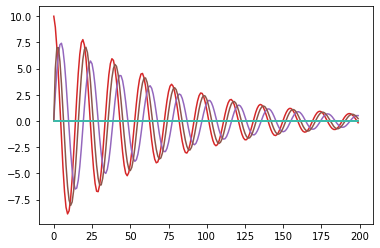

In [23]:
plt.plot(J[:, :].T);

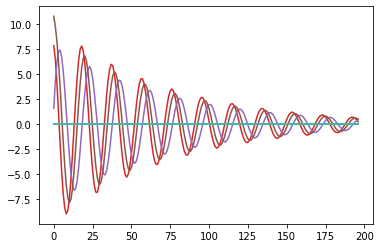

In [10]:
plt.plot(Jx[:, 2:].T);

In [21]:
clf.active_set[-1]

array([3, 4, 5])

In [61]:
100*np.linalg.norm(Jx[:, :].T - J[:, 1:].T)/np.linalg.norm(J[:, 1:].T)

33.779158139840995

In [22]:
results

,RMS_J,RMS_M,AS,RMS_A,NC
0,42.738861,34.740898,0.0,56.885864,-16.666667
